# Imports

In [1]:
import cv2
import importlib.resources as resources
import logging
import matplotlib.pyplot as plt
import numpy as np

from anypick_dk.constants import (
    q_Object, X_WCan, X_WGelatin, X_WMustard, X_WSugar
)
from anypick_dk.grasp_detector import GraspDetector
from anypick_dk.grounded_sam_wrapper import GroundedSamWrapper
from anypick_dk.planner import Planner
from anypick_dk.sim_environment import SimEnvironment
from anypick_dk.utils import get_pc_from_depth, save_point_cloud, transform_pointcloud
from pydrake.all import Concatenate, Rgba

logging.basicConfig(level=logging.INFO)

/usr/local/lib/python3.12/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
scenario_file = str(resources.files("anypick_dk") / "scenarios" / "shelf_with_objects.yaml")
gpd_config_file = str(resources.files("anypick_dk") / "cfg" / "gpd_params.cfg")

sim_env = SimEnvironment(scenario_file)
planner = Planner(sim_env)
grasp_detector = GraspDetector(gpd_config_file)
sim_env.publish_diagram()

INFO:drake:Meshcat listening for connections at http://localhost:7000


# View Camera Images

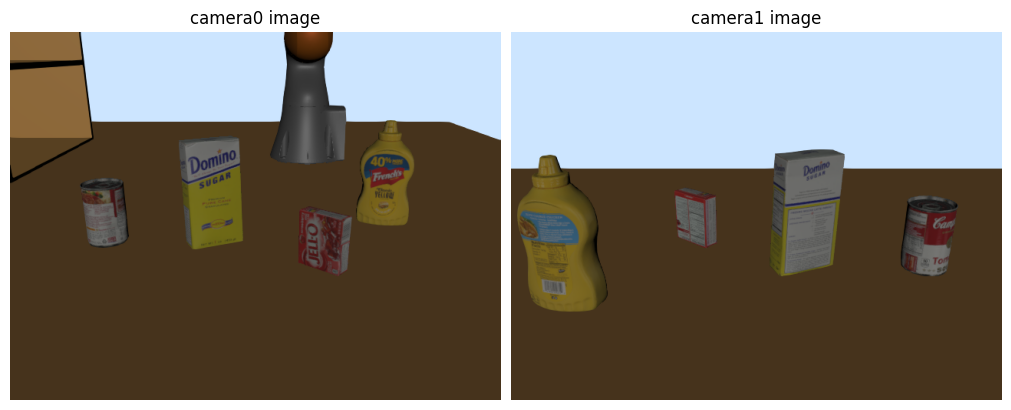

In [3]:
cameras = [0, 1]
fig, axes = plt.subplots(
    1, len(cameras), figsize=(5 * len(cameras), 4), constrained_layout=True
)
for ax, cam in zip(axes, cameras):
    img = sim_env.get_camera_bgr(cam)
    im = ax.imshow(img[:,:,::-1])
    ax.set_title(f"camera{cam} image")
    ax.axis("off")

plt.show()

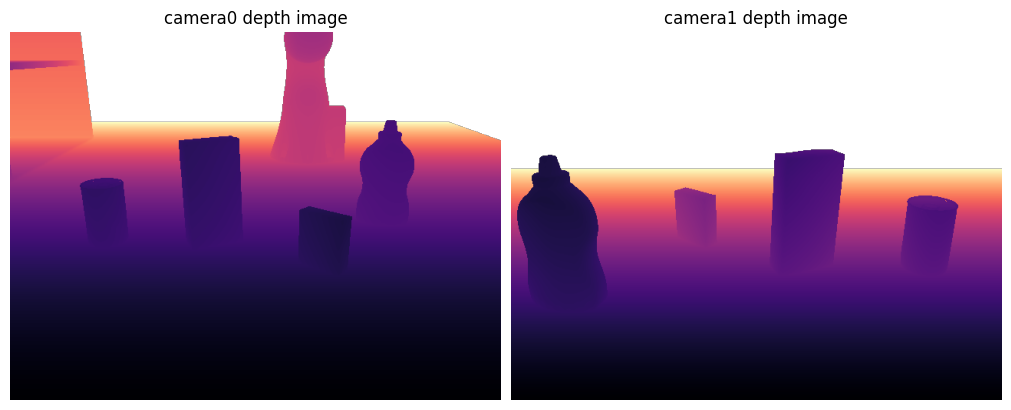

In [4]:
fig, axes = plt.subplots(
    1, len(cameras), figsize=(5 * len(cameras), 4), constrained_layout=True
)
for ax, cam in zip(axes, cameras):
    depth_img = sim_env.get_camera_depth(cam)
    img = ax.imshow(depth_img, cmap="magma")
    ax.set_title(f"camera{cam} depth image")
    ax.axis("off")

plt.show()

# Run GroundedSAM

Working prompts are:
- "the mustard bottle"
- "the red box" or "the red jello box"
- "the yellow and white box"
- "the can"

In [5]:
gdsam = GroundedSamWrapper()

final text_encoder_type: bert-base-uncased


In [6]:
prompt = ["the red box"]

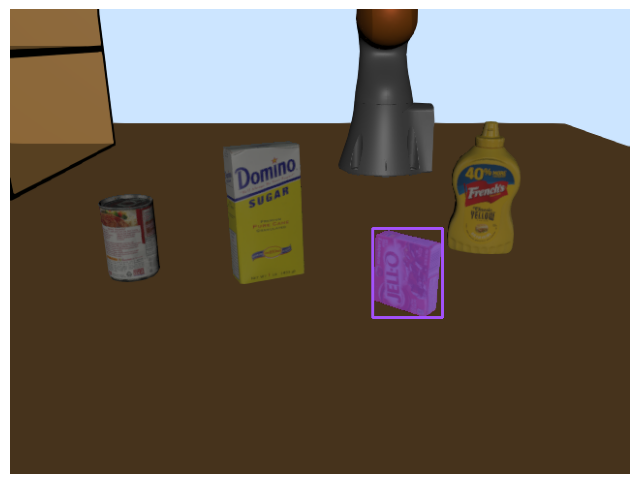

In [7]:
img0 = sim_env.get_camera_bgr(0)
bboxes0, masks0 = gdsam.detect_and_segment(img0, prompt)
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(gdsam.annotate(), cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

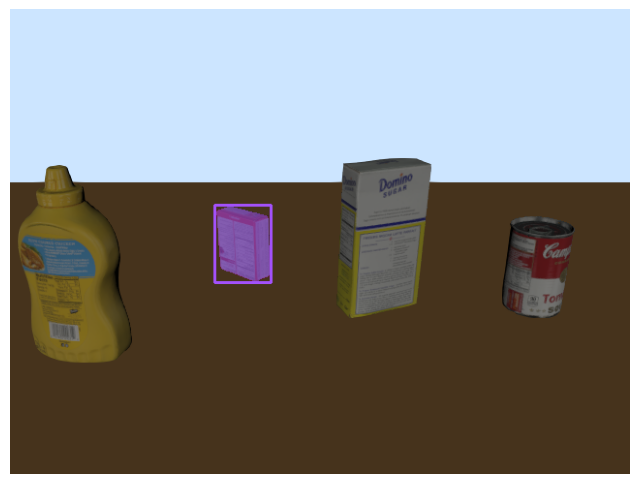

In [8]:
img1 = sim_env.get_camera_bgr(1)
bboxes1, masks1 = gdsam.detect_and_segment(img1, prompt)
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(gdsam.annotate(), cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Extract Point Cloud and Run GPD

In [12]:
kernel = np.ones((7, 7), np.uint8)
masks0_eroded = cv2.erode(masks0.astype(np.uint8) * 255, kernel, iterations=1).astype(bool)
masks1_eroded = cv2.erode(masks1.astype(np.uint8) * 255, kernel, iterations=1).astype(bool)

In [13]:
intrinsics0 = sim_env.get_camera_intrinsics(0)
depth_img0 = sim_env.get_camera_depth(0)
masked_depth0 = depth_img0.copy()
masked_depth0[~masks0_eroded] = 0.0
cam0_pc_local = get_pc_from_depth(masked_depth0, intrinsics0)
X_WC0 = sim_env.get_camera_pose(0)
cam0_pc_world = transform_pointcloud(cam0_pc_local, X_WC0)

In [14]:
intrinsics1 = sim_env.get_camera_intrinsics(1)
depth_img1 = sim_env.get_camera_depth(1)
masked_depth1 = depth_img.copy()
masked_depth1[~masks1_eroded] = 0.0
cam1_pc_local = get_pc_from_depth(masked_depth1, intrinsics1)
X_WC1 = sim_env.get_camera_pose(1)
cam1_pc_world = transform_pointcloud(cam1_pc_local, X_WC1)

In [15]:
obj_pc = Concatenate([cam0_pc_world, cam1_pc_world])
sim_env.meshcat.SetObject(
    "object_point_cloud", obj_pc, point_size=0.01, rgba=Rgba(1, 0, 0)
)
save_point_cloud(obj_pc, "obj_pc.pcd")

In [4]:
grasps = grasp_detector.detect_grasps("./obj_pc.pcd")
grasp = grasp_detector.get_best_grasp(grasps, planner)

INFO:anypick_dk.planner:IK success.
INFO:anypick_dk.planner:IK success.
ERROR:anypick_dk.planner:IK failed!
ERROR:anypick_dk.planner:IK failed!
INFO:anypick_dk.planner:IK success.
INFO:anypick_dk.planner:IK success.
INFO:anypick_dk.planner:IK success.
INFO:anypick_dk.planner:IK success.
INFO:anypick_dk.planner:IK success.
INFO:anypick_dk.planner:IK success.
ERROR:anypick_dk.planner:IK failed!
ERROR:anypick_dk.planner:IK failed!
INFO:anypick_dk.planner:IK success.
INFO:anypick_dk.planner:IK success.
INFO:anypick_dk.planner:IK success.
INFO:anypick_dk.planner:IK success.
INFO:anypick_dk.planner:IK success.
INFO:anypick_dk.planner:IK success.
INFO:anypick_dk.planner:IK success.
INFO:anypick_dk.planner:IK success.
INFO:anypick_dk.grasp_detector:Selected best grasp with score 1021.640 (2/20 grasps were valid).


In [5]:
sim_env.visualize_frame("grasp", grasp.to_drake())

In [6]:
sim_env.visualize_frame("wsg", planner.solve_fk())
sim_env.visualize_frame("sugar", X_WSugar)
sim_env.visualize_frame("can", X_WCan)
sim_env.visualize_frame("gelatin", X_WGelatin)
sim_env.visualize_frame("mustard", X_WMustard)

In [7]:
q_Pick = planner.solve_ik(grasps[1].to_drake(), q_Object)
sim_env.set_iiwa_position(q_Pick)
sim_env.publish_diagram()
print(q_Pick)

INFO:anypick_dk.planner:IK success.


[-1.30703679 -1.20615282 -0.65743645  0.99393665  0.65554205 -0.88359529
  2.70757079]
